## Capital One
### Data Science Challenge: Trips!

This coding challenge is designed to test your skill and intuition about real world data. For the challenge, we will use data collected by the New York City Taxi and Limousine commission about "Green" Taxis. Green Taxis (as opposed to yellow ones) are taxis that are not allowed to pick up passengers inside of the densely populated areas of Manhattan. We will use the data from September 2015. We are using NYC Taxi and Limousine trip record data: (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml).

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = matplotlib.rcParams['savefig.dpi']

from scipy import stats

#### Question 1

- Programmatically download and load into your favorite analytical tool the trip data for September 2015.
- Report how many rows and columns of data you have loaded.

The following steps are taken to retrieve the data:
* 'BeautifulSoup' package is used to parse the web site html document
* all links that match strings compatible with color, year, month are selected
* a cached version of the data is saved on disk to speed up future data loads

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import os.path

def loadData(clr, yr, mn):
    yr = str(yr)
    mn = str(mn)

    url = "http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml"
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    regex = re.compile('.*'+clr+".*"+yr+'.*'+mn)
    link = soup.find('a', href=regex)['href']

    fname = re.findall(re.compile(clr+'.*$'), link)[0]

    if not os.path.isfile(fname):
        data = pd.DataFrame.from_csv(link, parse_dates=['lpep_pickup_datetime', 'Lpep_dropoff_datetime'])
        data.to_csv(fname)
    else:
        data = pd.DataFrame.from_csv(fname, parse_dates=['lpep_pickup_datetime', 'Lpep_dropoff_datetime'])
    return data

data = loadData('green', 2015, 9)
print "Number of rows: ", data.shape[0]
print "Number of columns: ", data.shape[1]

Number of rows:  1494926
Number of columns:  21


### Question 2

- Plot a histogram of the number of the trip distance ("Trip Distance").
- Report any structure you find and any hypotheses you have about that structure.

In [48]:
# predata cleaning
# Trip distance, Total_amount, Pickup_latitude
dataNZ = data[(data.Trip_distance > 1e-2) &
              (data.Total_amount > 5) & 
              (data.Fare_amount > 2.51) &
              (data.Pickup_latitude != 0) & 
              (data.Pickup_longitude != 0) &
              (data.Dropoff_latitude != 0) & 
              (data.Dropoff_longitude != 0)]

#### Filter decision:
* There are some data with trip distances equal to zero. These data points are filtered. It is not necessarily associated with equipment malfunction, but rather with the common practice of taxi drivers of negotiating a long trip price before hand, and stopping the meter so that they receive the entire trip payment as a tip.
* When the total_amount is less than 5 and the Fare_amount is less than 2.51, the data points are considered abnormal, especially when observing the tip precentage,thus those data points are removed.
* There are also few data points where the locations are 0, those are removed as well.

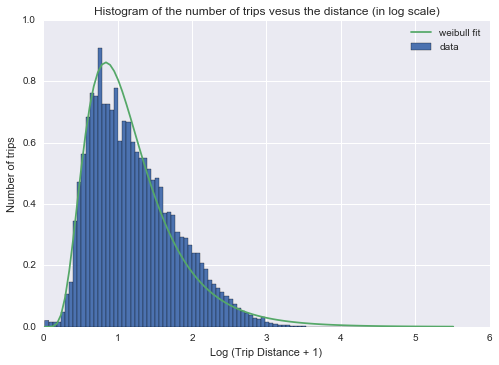

In [49]:
triploglen = np.log1p(dataNZ.Trip_distance.values)
params = stats.exponweib.fit(triploglen, 1,0, scale=2, loc=0)

n = plt.hist(triploglen, normed=True, bins=100)
plt.plot(n[1], stats.exponweib.pdf(n[1],*params))
plt.xlabel('Log (Trip Distance + 1)')
plt.ylabel('Number of trips')
plt.title('Histogram of the number of trips vesus the distance (in log scale)')
plt.legend(['weibull fit', 'data'])

#### Observations:
* The trip distance varies in range (0, 600) miles. To show the histogram, the x-axis is plotted in log (x+1) scale. log(x+1) is necessary since there are many trips that are less than 1 mile. With this histogram, the data fit every nicely to a Weibull distribution.


### Question 3

- Report mean and median trip distance grouped by hour of day.
- We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.

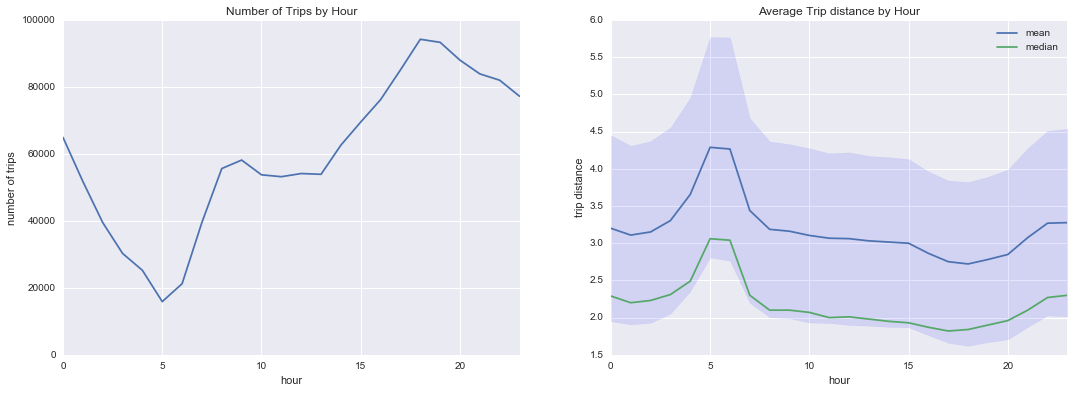

In [74]:
dataNZ.index = dataNZ.lpep_pickup_datetime
data_groupbyhour = dataNZ.groupby(dataNZ.index.hour)
dataNZ.reset_index(drop=True, inplace=True)

plt.figure(figsize=([18,6]))
plt.subplot(1,2,1)
plt.plot(data_groupbyhour.size())
plt.xlabel('hour')
plt.ylabel('number of trips')
plt.title('Number of Trips by Hour')
plt.xlim([0, 23])
plt.ylim([0, 100000])
dist_std = data_groupbyhour.Trip_distance.quantile(q=0.25).values
dist_mean = data_groupbyhour.Trip_distance.mean().values
dist_media = data_groupbyhour.Trip_distance.median().values

plt.subplot(1,2,2)
plt.plot(dist_mean)
plt.fill_between(range(24), dist_mean-dist_std, dist_mean+dist_std, color='b', alpha = 0.1)
plt.plot(dist_media)
plt.xlim([0, 23])
plt.legend(['mean', 'median'])
plt.xlabel('hour')
plt.ylabel('trip distance')
plt.title('Average Trip distance by Hour')


#### Observations:
* The number of trips by the hours is consistent with the daily activity. With the lowest number of rides at 5am, and highest number of rides around 5pm. 
* The trip distance shows very interesting trend. First of all, there is a consistent difference between mean and median. This can explained from the distribution of the trip distance. As observed from the histogram, there is a heavy tail at the distribution. The data within .25 percentile is ploted in shade to show the range of variation in the data. 
* The trip distance the longest for the ride around 5am. This is probably due to the lack of public transportation, and can be people going to the airports.

#### Airport stats:
In order to select the trips that begin/end to one of the aiports in the area, the GPS location of each airport is defined.  It is further assumed that shape of the airport is a rectangle centered at the GPS location of the airports.  The size of each airport is different, with LGA's square size twice as small as JFK and EWR.

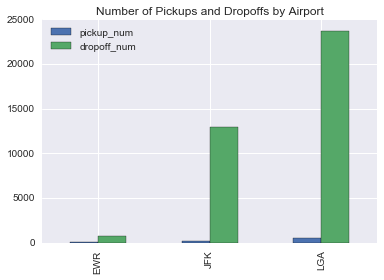

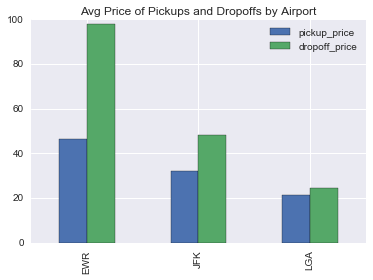

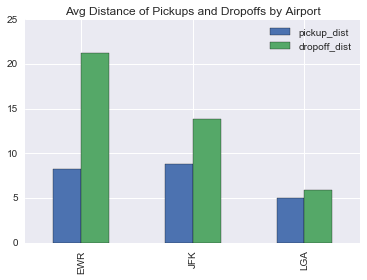

In [387]:
airportLL = {'LGA': [-73.865012, 40.770841, 0.01],
             'JFK': [-73.782108, 40.643631, 0.02],
             'EWR': [-74.182992, 40.692624, 0.02]}
bar_width = 0.3

def addAirportIndicator( data, airportLL):
    data['airport_pickup'] = np.nan
    data['airport_dropoff'] = np.nan
    for key, value in airportLL.items():
        data.loc[((data.Pickup_longitude > value[0]-value[2]) &\
             (data.Pickup_longitude < value[0]+value[2]) &\
             (data.Pickup_latitude  > value[1]-value[2]) &\
             (data.Pickup_latitude  < value[1]+value[2])), 'airport_pickup'] = key
        
        data.loc[((data.Dropoff_longitude > value[0]-value[2]) &\
            (data.Dropoff_longitude < value[0]+value[2]) &\
            (data.Dropoff_latitude  > value[1]-value[2]) &\
            (data.Dropoff_latitude  < value[1]+value[2])), 'airport_dropoff'] = key 
        
addAirportIndicator(dataNZ, airportLL)
a_data = pd.DataFrame.from_dict(
    {'pickup_num': dataNZ.groupby('airport_pickup').size(), 
     'dropoff_num': dataNZ.groupby('airport_dropoff').size(),
     'pickup_price': dataNZ.groupby('airport_pickup').Total_amount.mean(), 
     'dropoff_price': dataNZ.groupby('airport_dropoff').Total_amount.mean(),
     'pickup_dist': dataNZ.groupby('airport_pickup').Trip_distance.mean(), 
     'dropoff_dist': dataNZ.groupby('airport_dropoff').Trip_distance.mean()})
a_data[['pickup_num', 'dropoff_num']].plot.bar(title = 'Number of Pickups and Dropoffs by Airport')
a_data[['pickup_price', 'dropoff_price']].plot.bar(title = 'Avg Price of Pickups and Dropoffs by Airport')
a_data[['pickup_dist', 'dropoff_dist']].plot.bar(title = 'Avg Distance of Pickups and Dropoffs by Airport')

### Question 4

- Build a derived variable for tip as a percentage of the total fare.
- Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample.

There are instances when the tip amount cannot be computed accurately as a percentace of total amount.  We filter out the following cases:
1. the fare_amount < 5 (this would result in division by zero error)
2. Tip_percent == 0 (the taxi driver most likely did not report the true value of the tip, for tax avoidance purposes). When looking at the payment pay type, teh majority is in cash
3. Tip_percent in interval (1, 150).  It is assumed that no customer would pay at tip larger than the total amount of the trip.  A closer look at the data points in this category shows that similar to the observation in Question 1, the drivers negotiate a long distance price, start and stop the counter for a short period, and pocket the total amount as tip.  That causes the data to have spurious large percentage tips that don't have a correspondent in real life situations.  For example we added a plot that shows this case with the y-axis different from the total histogram plot, so that data can be visualized.

In [121]:
# tip range selection & cleaning
validFare = dataNZ
validFare.loc[:,'Tip_percent'] = (validFare.Tip_amount/validFare.Fare_amount)
validFare_tip
tip_group = validFare.groupby(pd.cut(validFare.Tip_percent, np.array([-0.01,0.01,1,150])))
validFare_tip = tip_group.get_group('(0.01, 1]')
cash = {}
creditcard = {}
for k in tip_group.groups.keys():
    cash[k] = sum(tip_group.get_group(k).Payment_type==2)
    creditcard[k] = sum(tip_group.get_group(k).Payment_type==1)   
    
pd.DataFrame([tip_group.size(), pd.Series(cash), pd.Series(creditcard)], 
                   index=['Total Number', 'Cash', 'Credit'])

Tip_percent,"(-0.01, 0.01]","(0.01, 1]","(1, 150]"
Total Number,835065,593130,1197
Cash,736354,1,0
Credit,93559,593128,1197


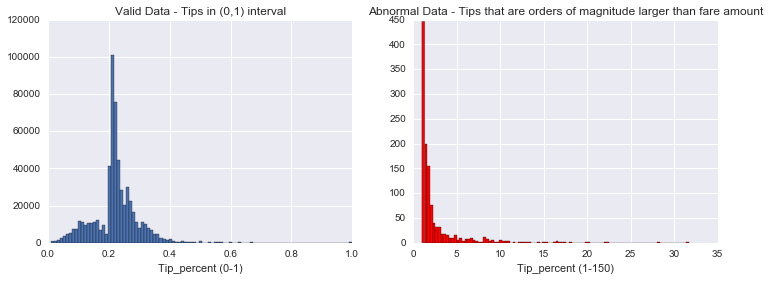

In [122]:
plt.figure(figsize = ([12,4]))
plt.subplot(1,2,1)
plt.hist(validFare_tip.Tip_percent, bins=100)
plt.xlabel('Tip_percent (0-1)')
plt.title('Valid Data - Tips in (0,1) interval')

plt.subplot(1,2,2)
plt.hist(validFare[(validFare.Tip_percent>1)].Tip_percent, color = 'r', bins=100)
plt.xlabel('Tip_percent (1-150)')
plt.title('Abnormal Data - Tips that are orders of magnitude larger than fare amount')

#### Observation:
From the histogram of the tip_percent, the data is highly peaked around 20%.  This is expected as most of the credit card interface pay system have preset values for the tip as a percentage.

#### Tip percentage predition model
Linear regressor and gradeint boosting (GB) regressor are compared to the mean model. The linear regressor has the limitation of using only numerical features, while GB regressor can take all types of input.  Additional features such as geographical coordinates, time, trip types were considered. Two additional features, the trip hour and trip weekday are extracted from the pickup time for training. 

A comparison of the models in mean_squared_error:
* using the total mean of the percentage sample
* regular regression model (OLS) with the same features
* random forest regressor
* gradient boosting regressor


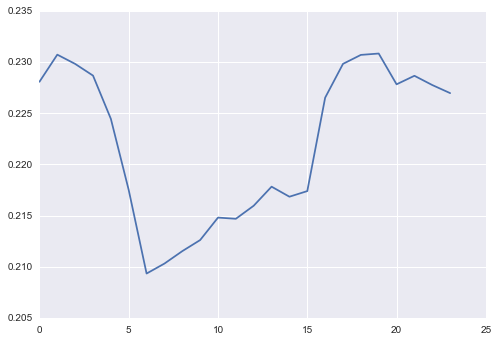

In [154]:
validFare_tip.index = validFare_tip.lpep_pickup_datetime
validFare_tip.loc[:,'hour'] = validFare_tip.index.hour
validFare_tip.loc[:,'weekday'] = validFare_tip.index.weekday
validFare_tip.reset_index(drop=True, inplace=True)

plt.subplot(2,2,1)
plt.plot(validFare_tip.groupby('hour').Tip_percent.mean())
plt.subplot(2,2,2)
plt.plot(validFare_tip.groupby('weekday').Tip_percent.mean())
f = [u'Trip_distance', u'Fare_amount']
plt.scatter(validFare_tip.Trip_distance, validFare_tip.Ti)


In [136]:
from sklearn import cross_validation, linear_model, ensemble


y = validFare_tip.Tip_percent
X = validFare_tip.drop(['Tip_percent'], axis=1)

cv = cross_validation.ShuffleSplit(len(X), n_iter=3, test_size=0.3, random_state=42)
def compute_error(est, X, y):
    return -cross_validation.cross_val_score(est, X, y, cv=cv, scoring='mean_squared_error').mean()

features_lin = [u'Passenger_count', u'Trip_distance', u'Fare_amount',u'Tolls_amount',]
features_gb = ['hour', 'weekday',
               u'Pickup_longitude', u'Pickup_latitude', u'Dropoff_longitude', 
               u'Dropoff_latitude', u'Passenger_count', u'Trip_distance',
               u'RateCodeID',u'Extra',u'MTA_tax',u'Tolls_amount',u'Fare_amount']

linreg = linear_model.LinearRegression()
randomforest = ensemble.RandomForestRegressor(max_depth=3)
GB = ensemble.GradientBoostingRegressor(max_depth=5)
model_performance = pd.DataFrame([
    ("Mean Model", y.var()),
    ("OLS", compute_error(linreg, X[features_lin], y)),
    ("RF"), compute_error(randomforest, X[features_gb], y)
    ("GB"), compute_error(GB, X[features_gb], y)),
    ], columns=["Model", "MSE"])

model_performance.set_index("Model")
model_performance.plot(x="Model", y="MSE", kind="Bar")

TypeError: 'numpy.float64' object is not callable

In [137]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
    X, y, test_size = 0.3, random_state = 42)

GB = ensemble.GradientBoostingRegressor(max_depth=5, n_estimators=100)
GB_fit = GB.fit(X_train[features_gb], y_train)
GB.score(X_test[features_gb], y_test)

0.15256333020991408

In [142]:
import dill
dill.dump(GB_fit, open('GB_fit.d','w'))

### Question 5

Cluster the data based on locations, and using the cluster labels as additional feature to predict the tip percentage

This is a geographical representation of the pickup and drop off locations.  One can clearly single out the four boroughs where the green taxis operate.

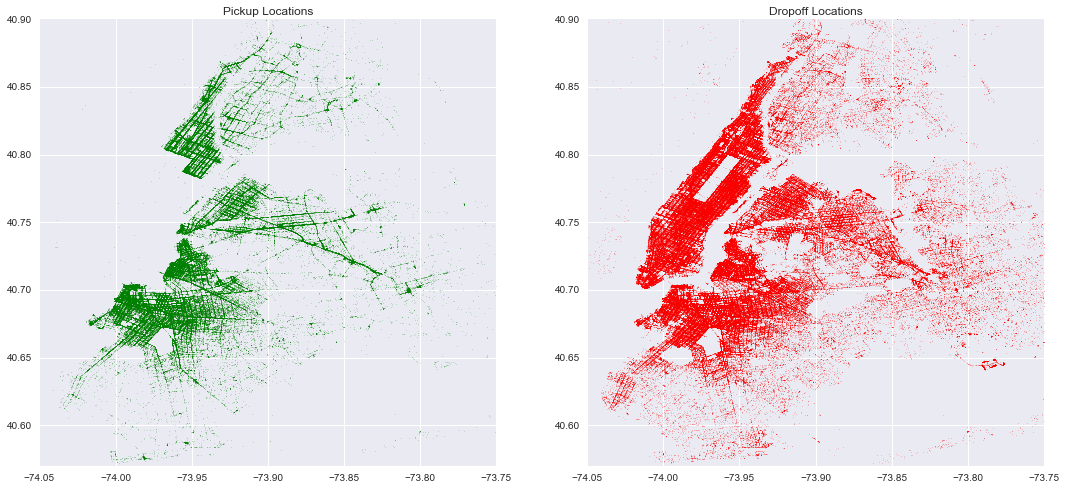

In [144]:
def plotLocation(data):
    plt.figure(figsize = ([18,8]))
    ax1 = plt.subplot(1,2,1)
    ax1.scatter(x=data.Pickup_longitude, y=data.Pickup_latitude,color='green', s = 0.1, alpha = 0.5)
    ax1.set_xlim([-74.05,-73.75])
    ax1.set_ylim([40.57, 40.90])
    ax1.set_title('Pickup Locations')
    plt.subplot(1,2,2)
    ax2 = plt.subplot(1,2,2)
    ax2.scatter(x=data.Dropoff_longitude, y=data.Dropoff_latitude,color='red', s = 0.1, alpha = 0.5)
    ax2.set_xlim([-74.05,-73.75])
    ax2.set_ylim([40.57, 40.90])
    ax2.set_title('Dropoff Locations')
    
plotLocation(validFare_tip)

It is noticeable that the pick up locations tend to be more concentrated on the main avenues in the city, therefore the clustering algorithm uses the drop off locations, which are more indicative of demographics of clients, and in turn may affect the total tip variable.

The purpose of the next section is to use a clustering algorithm that is able to cluster the data in a similar way to the geographical boroughs.  Out of three clustering algorithms, K-means, Spectral Clustering, and DBSCAN, DBSCAN performs best.  The other clustering algorithms analysis was not included.  

DBSCAN is extremely intensive, there fore the algorithm is run on 200,000 data points, assuming the order of data is random. After DBSCAN, K-nearest-neighbor classifier is used to predict the cluster for the rest of the dataset.

Here is the plot for the clusters.  Data well outside the city in Long Island and Brooklyn was removed because it's too sparse and it's interfering with the clustering algorithm.  Approximately 80% of the total points used in DBSCAN belong to the clusters. 

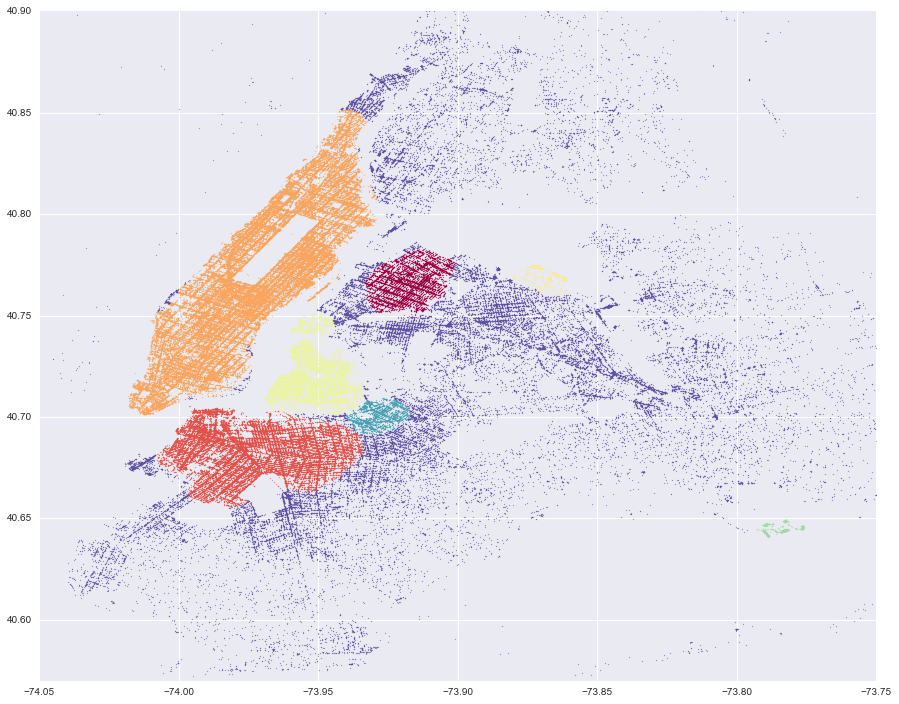

In [145]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

def plotClusters(labels, X):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0,1,len(unique_labels)))
    plt.figure(figsize = ([15, 12]))
    ax = plt.subplot(1,1,1)
    ax.set_xlim([-74.05,-73.75])
    ax.set_ylim([40.57, 40.90])
    for k, col in zip(unique_labels, colors):
        plt.scatter(x=X.Dropoff_longitude[labels==k], 
                    y=X.Dropoff_latitude[labels==k], 
                    color=col, s = 1, alpha = 0.5)

Xcluster = validFare_tip.head(200000)
db = DBSCAN(eps=.54e-2, min_samples=1000).fit(Xcluster[['Dropoff_longitude', 'Dropoff_latitude']])
plotClusters(db.labels_, Xcluster)

We can easily identify the following clusters:
* Manhattan
* South Brooklyn
* Williamsburg
* Queens (Astoria)
* LGA airport
* JFK airport
* Bushwick, Brooklyn is also considered a separate cluster, another trendy area

One observation is that the DBSCAN is sensitive to the hyperparamter, eps, which defines the maximum distance between two samples for them to be considered as in the same neighborhood. 

This is how the geographical distribution of all data points looks like, with KNN classifier, with the points that do not belong to any cluster added to the map.

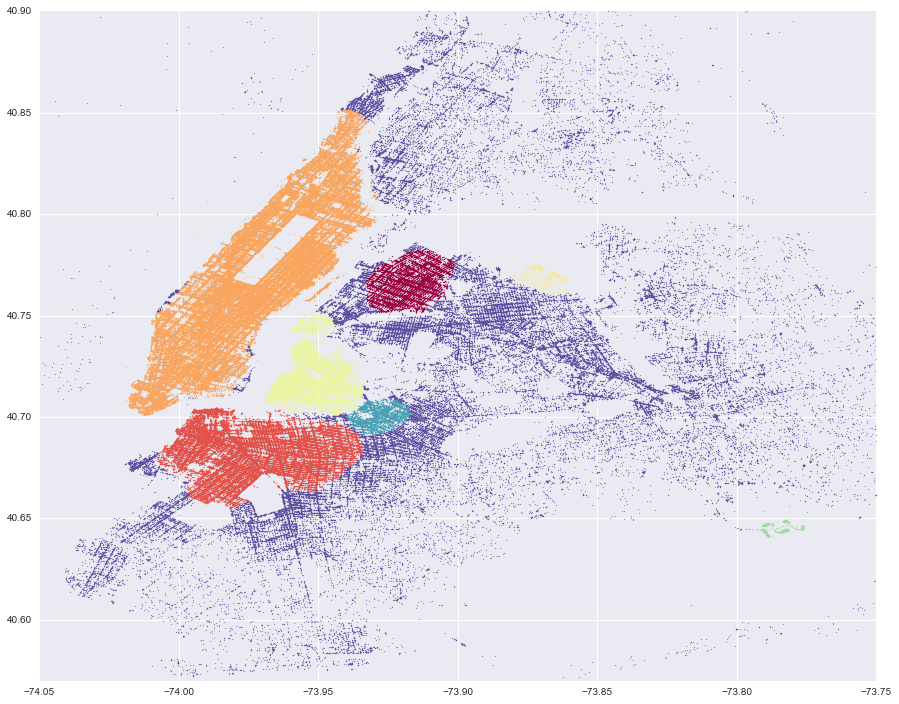

In [149]:
from sklearn.neighbors import KNeighborsClassifier
Xknn_test = validFare_tip[200000:]

Xcluster.loc[:,'clusters'] = db.labels_
knn = KNeighborsClassifier(n_neighbors=8).fit(Xcluster[['Dropoff_longitude', 'Dropoff_latitude']], Xcluster['clusters'])
knnpredict = knn.predict(Xknn_test[['Dropoff_longitude', 'Dropoff_latitude']])
Xknn_test.loc[:,'clusters'] = knnpredict

labels = pd.Series(knnpredict).value_counts().index
colors = plt.cm.Spectral(np.linspace(0,1,len(labels)))

plt.figure(figsize = ([15, 12]))
plotClusters(knnpredict, Xknn_test)

The next step is to used the Gradient Booster method (GB) to predict the tip amount per cluster, and see if the prediction is improved relative to the one computed in Question 4.  All we need to do is to include the new clusters in the feature list, and GB automatically takes that into account as a relevant variable.

In [153]:
validFare_tip.loc[:,'clusters']=pd.concat([Xcluster.clusters, Xknn_test.clusters])
validFare_tip.clusters.fillna(-1, inplace=True)

features_gb = ['hour', 'weekday',
               u'Pickup_longitude', u'Pickup_latitude', u'Dropoff_longitude', 
               u'Dropoff_latitude', u'Passenger_count', u'Trip_distance',
               u'RateCodeID',u'Extra',u'MTA_tax',u'Tolls_amount',u'Fare_amount', 'clusters']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
    validFare_tip, y, test_size = 0.7, random_state = 0)

GB = ensemble.GradientBoostingRegressor(max_depth=5, n_estimators=200)
GB.fit(X_train[features_gb], y_train)
GB.score(X_test[features_gb], y_test)

0.1427261223703995

### Conclusion
With the addtional cluster indication, the GB algorithms performs only slightly better for the R^2 score. 

As observed from the plots based on different features, the tip percentage is almost uniform for large range of the features such as fare amount, trip_distance. There are also slight variations in the average tip percentage based on different clustering, but the variation is very large. 

Despite using quite very sophisticated models, the score (R-squred) is only slightly better than the naive direct mean of the total population sample.  The process of chosing the tip as a percentage of the total fare is dominiated by the payment preset selections, and has little corretation to other features of the trip.